# Použité knihovny

In [ ]:
import wfdb
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

Nalezené soubory: ['100002_ACC.dat', '100002_ANN.csv', '100002_ECG.hea', '100002_ECG.dat', '100002_ACC.hea']
Nalezené signály: {'100002_ECG', '100002_ACC'}
Metadata signálu: {'fs': 1000, 'sig_len': 86762000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['uV'], 'sig_name': ['ECG'], 'comments': ['ECG']}


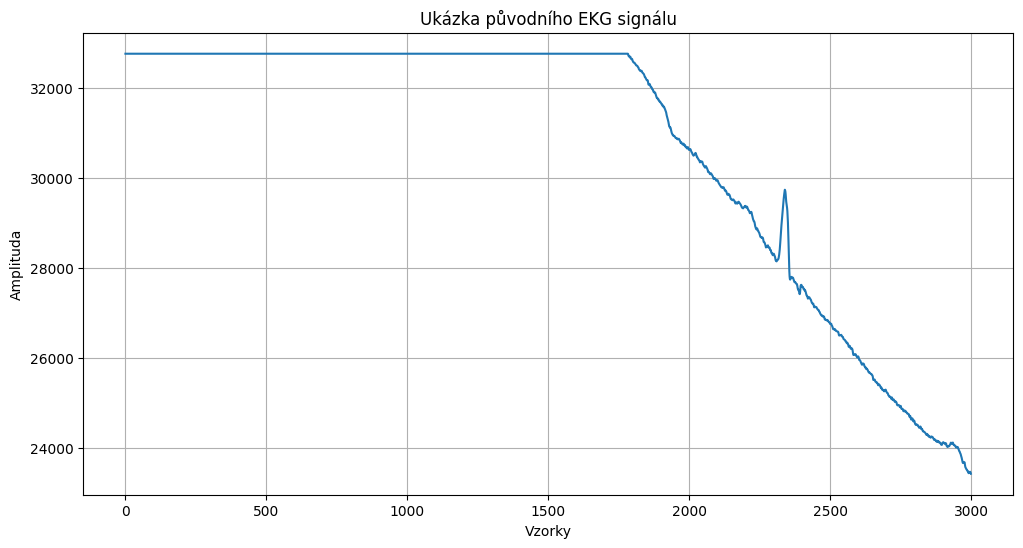

Používá se filtrovaný signál.


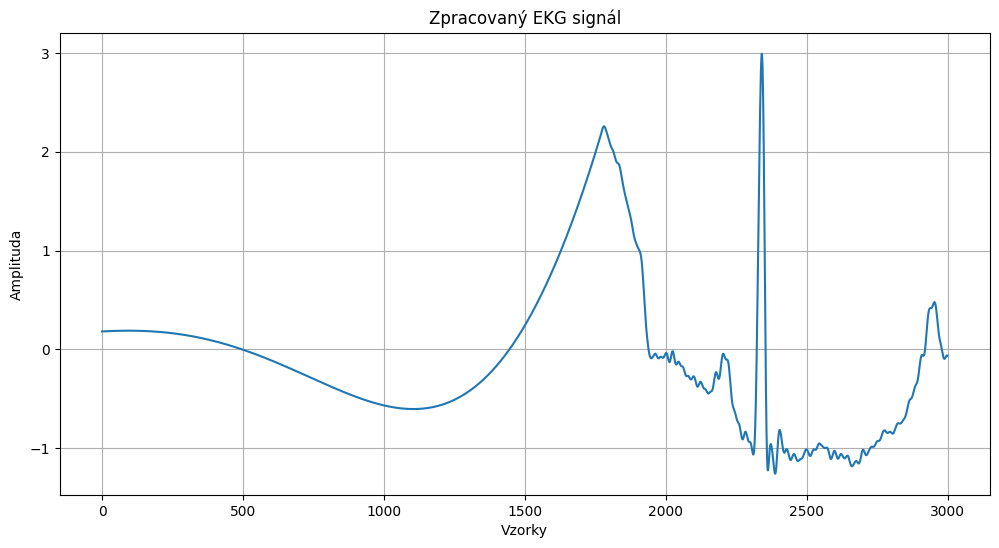

Počet detekovaných R vrcholů: 184334
Průměrná tepová frekvence: 127.48 BPM


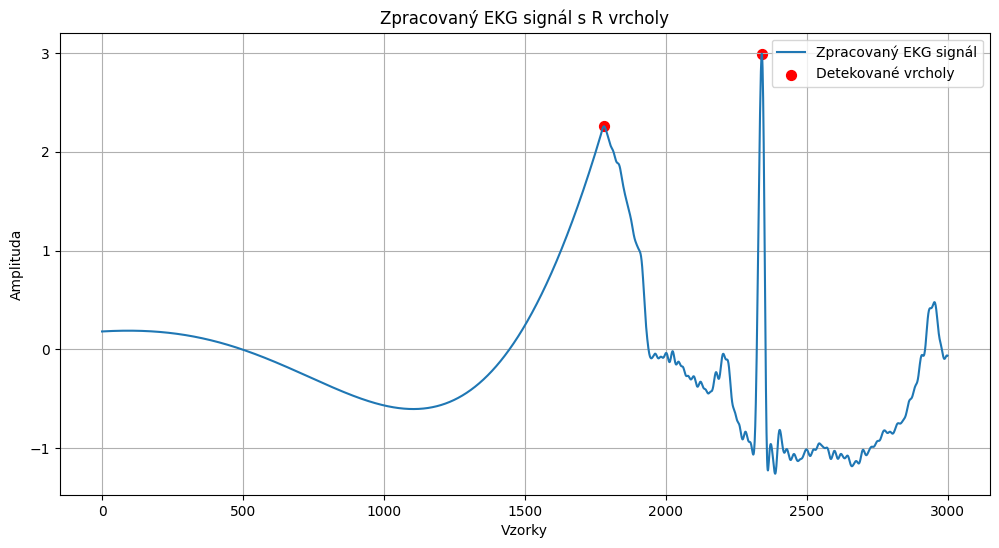

In [3]:


# Adresář s daty
ekg_directory = "bpm/100002"

# Načtení všech dostupných souborů ve složce
files = os.listdir(ekg_directory)

# Filtrujeme základní názvy souborů signálu (bez přípon)
signal_basenames = set(f.split(".")[0] for f in files if f.endswith(".dat"))

# Pracujeme s prvním signálem
if len(signal_basenames) > 0:
    signal_basename = list(signal_basenames)[0]
    record_path = os.path.join(ekg_directory, signal_basename)

    # Načtení signálu
    record = wfdb.rdsamp(record_path)
    signal = record[0][:, 0]  # První kanál
    fields = record[1]

    # Parametry pro ladění
    sampling_frequency = fields["fs"]  # Vzorkovací frekvence (Hz)
    lowcut = 0.5  # Dolní hranice pásmové filtrace (Hz)
    highcut = 50.0  # Horní hranice pásmové filtrace (Hz)
    filter_order = 4  # Pořadí filtru
    threshold = 0.5  # Práh pro detekci R vrcholů
    display_samples = 3000  # Počet vzorků pro zobrazení (pro grafy)
    use_filter = True  # Přepínání mezi filtrovaným a nefiltrovaným signálem

    # Zobrazení metadat
    print("Metadata signálu:", fields)

    # Vizualizace původního signálu
    plt.figure(figsize=(12, 6))
    plt.plot(signal[:display_samples])
    plt.title("Ukázka původního EKG signálu")
    plt.xlabel("Vzorky")
    plt.ylabel("Amplituda")
    plt.grid()
    plt.show()

    # Kontrola rozsahu signálu
    signal_range = np.max(signal) - np.min(signal)
    if signal_range < 0.01:
        raise ValueError("Signál má příliš malý rozsah, což naznačuje chybu v datech.")

    # Normalizace signálu
    signal_normalized = (signal - np.mean(signal)) / np.std(signal)

    # Funkce pro pásmovou filtrační metodu
    def bandpass_filter(signal, lowcut, highcut, fs, order):
        nyquist = 0.5 * fs
        if lowcut >= nyquist or highcut >= nyquist:
            raise ValueError(
                "Filtrační frekvence musí být menší než polovina vzorkovací frekvence (Nyquistova frekvence)."
            )
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype="band")
        return filtfilt(b, a, signal)

    # Aplikace filtrace
    if use_filter:
        try:
            signal_processed = bandpass_filter(signal_normalized, lowcut, highcut, sampling_frequency, filter_order)
            print("Používá se filtrovaný signál.")
        except ValueError as e:
            print(f"Chyba filtrace: {e}")
            signal_processed = signal_normalized
    else:
        signal_processed = signal_normalized
        print("Používá se nefiltrovaný signál.")

    # Vizualizace signálu po zpracování
    plt.figure(figsize=(12, 6))
    plt.plot(signal_processed[:display_samples])
    plt.title("Zpracovaný EKG signál")
    plt.xlabel("Vzorky")
    plt.ylabel("Amplituda")
    plt.grid()
    plt.show()

    # Derivace signálu
    derivative = np.gradient(signal_processed)

    # Hledání nulových průchodů podle derivace
    zero_crossings = np.where((derivative[:-1] > 0) & (derivative[1:] < 0))[0]

    # Filtrování nulových průchodů podle amplitudy (práh)
    peaks = zero_crossings[signal_processed[zero_crossings] > threshold]

    # Zajištění stejného počtu vzorků pro signal_processed a detekované vrcholy
    peaks = peaks[peaks < len(signal_processed)]

    # Výpočet tepové frekvence
    if len(peaks) > 1:
        r_peak_intervals = np.diff(peaks) / sampling_frequency  # Intervaly mezi R vrcholy
        heart_rate = 60 / np.mean(r_peak_intervals) if len(r_peak_intervals) > 0 else 0
    else:
        heart_rate = 0

    print(f"Počet detekovaných R vrcholů: {len(peaks)}")
    print(f"Průměrná tepová frekvence: {heart_rate:.2f} BPM")

    # Vizualizace filtrovaného signálu s detekovanými R vrcholy
    plt.figure(figsize=(12, 6))
    plt.plot(signal_processed[:display_samples], label="Zpracovaný EKG signál")
    plt.scatter(
        peaks[peaks < display_samples],
        signal_processed[peaks[peaks < display_samples]],
        color="red",
        label="Detekované vrcholy",
        s=50,
    )
    plt.title("Zpracovaný EKG signál s R vrcholy")
    plt.xlabel("Vzorky")
    plt.ylabel("Amplituda")
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("Žádné EKG signály nebyly nalezeny ve složce.")
